# STOR 566 Final Project

Wei Chen, Rohan Iyer, Sam Ferguson, Gary Zhang

In [1]:
import torch
import numpy as np
import pandas as pd
from IPython.core.display import HTML
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, TrainingArguments, Trainer
import datasets
import evaluate

## Pre-trained model

These cells are simply for playing around with the pre-trained model. You don't have to run them to use the later cells.

In [ ]:
zero_shot_pipeline = pipeline('zero-shot-classification', model='typeform/distilbert-base-uncased-mnli')

sequences = [
    "I like to dance.",
    "We need healthcare for every American."
]

candidate_labels = [
    "Bernie Sanders would vote for this bill.",
    "Mitt Romney would vote for this.",
    "Mitch McConnell would vote for this bill.",
    "Ronald McDonald would vote for this bill."
]

out = zero_shot_pipeline(sequences, candidate_labels, multi_label = True)

for dictionary in out:
    print(dictionary["sequence"])
    labels = dictionary["labels"]
    scores = dictionary["scores"]
    for k in range(len(labels)):
        # nice formatting for labels and scores
        print("{:<50} {:<7.3f}".format(labels[k], scores[k]))
    print("")

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


I like to dance.
Ronald McDonald would vote for this bill.          0.303  
Mitt Romney would vote for this.                   0.217  
Bernie Sanders would vote for this bill.           0.175  
Mitch McConnell would vote for this bill.          0.091  

We need healthcare for every American.
Ronald McDonald would vote for this bill.          0.140  
Bernie Sanders would vote for this bill.           0.129  
Mitt Romney would vote for this.                   0.107  
Mitch McConnell would vote for this bill.          0.033  



In [ ]:
tokenizer = AutoTokenizer.from_pretrained("typeform/distilbert-base-uncased-mnli")
model     = AutoModelForSequenceClassification.from_pretrained(
    "typeform/distilbert-base-uncased-mnli",
) 

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
example_seq = tokenizer(
    #"This bill seeks to expand healthcare for working Americans",
    #"A senator who wants to expand healthcare would vote for this bill",
    "This bill will lower the cost of salads", "People who want to pay less for salads will like this bill",
    return_tensors="pt"
)

with torch.no_grad():
    output = model(**example_seq)
    logits = output.logits
    print(output)

predicted_class_id = logits.argmax().item()
print(predicted_class_id)
print(model.config.id2label[predicted_class_id])

SequenceClassifierOutput(loss=None, logits=tensor([[-3.8904,  2.4350,  2.2923]]), hidden_states=None, attentions=None)
1
NEUTRAL


## Data pre-processing

In [ ]:
# Pre-process 2021 senate votes dataframe
train_df_2021 = pd.read_csv(
    "SenateVotes120k.csv",
    skiprows = 0,
    header = 1
)

train_df_2021 = train_df_2021.drop(columns = "0")

# We can't feed the Policy column directly to the model. We'll remove the part before the column,
# and then we'll transform the Policy string into a complete sentence, which is required for our
# model to perform natural language inference.
def policy_to_NLI_2021(policy_str):
    first_colon_index = policy_str.index(":")
    bill_type = policy_str[:first_colon_index]
    policy_contents = policy_str[first_colon_index + 2:first_colon_index + 3].lower() + policy_str[first_colon_index + 3:]
    
    if bill_type == "Measure Title":
        nli_str  = "This is " + policy_contents
    if bill_type == "Statement of Purpose":
        nli_str  = "This bill serves " + policy_contents
    if bill_type == "Nomination Description":
        nli_str  = ""
    if bill_type == "Treaty Title":
        nli_str  = "This treaty is " + policy_contents

    return nli_str

def get_state(abbreviation):
    states = {"AK": "Alaska", "AL": "Alabama", "AR": "Arkansas", "AS": "American Samoa", "AZ": "Arizona", "CA": "California", "CO": "Colorado", "CT": "Connecticut", "DC": "District of Columbia", "DE": "Delaware", "FL": "Florida", "GA": "Georgia", "GU": "Guam", "HI": "Hawaii", "IA": "Iowa", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "MA": "Massachusetts", "MD": "Maryland", "ME": "Maine", "MI": "Michigan", "MN": "Minnesota", "MO": "Missouri", "MP": "Northern Mariana Islands", "MS": "Mississippi", "MT": "Montana", "NA": "National", "NC": "North Carolina", "ND": "North Dakota", "NE": "Nebraska", "NH": "New Hampshire", "NJ": "New Jersey", "NM": "New Mexico", "NV": "Nevada", "NY": "New York", "OH": "Ohio", "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania", "PR": "Puerto Rico", "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota", "TN": "Tennessee", "TX": "Texas", "UT": "Utah", "VA": "Virginia", "VI": "Virgin Islands", "VT": "Vermont", "WA": "Washington", "WI": "Wisconsin", "WV": "West Virginia", "WY": "Wyoming"}        
    return states[abbreviation]

def get_party(party):
    if   party == "D": return "democrat"
    elif party == "R": return "republican"
    elif party == "I": return "independent"
    else: pass
    
# For senator votes, we drop votes that are "gui" or "pres", then we convert the remainder into
# a Series (aka column) containing integers where yea is 2 and everything else is 0. This corresponds
# to Distilbert MNLI's predefined labels where a label of 2 is CONTRADICTION and 0 is ENTAILMENT. A label
# of 1 corresponds to NEUTRAL, but we aren't using that here.
train_df_2021 = train_df_2021.loc[(train_df_2021["Vote"] != "Gui") & (train_df_2021["Vote"] != "Pres")]
train_df_2021["Vote"] = 2 - pd.Series(train_df_2021["Vote"] == "Yea", dtype = int) * 2

# create an natural language inference (NLI) version of each policy for our model to train on
train_df_2021["Policy_NLI"]  = train_df_2021["Policy"].apply(policy_to_NLI_2021)
train_df_2021["Senator_NLI"] = train_df_2021["Name"] + ", a " + \
                               train_df_2021["Party"].apply(get_party) + " from " + \
                               train_df_2021["State"].apply(get_state) + ", would vote for this."

# Drop bills that are nothing more than presidential nominations
train_df_2021 = train_df_2021.loc[train_df_2021["Policy_NLI"] != ""]

display(train_df_2021)

,Year,Bill,Name,Party,State,Vote,PolicyID,Policy,Policy_NLI,Senator_NLI
0,2021,1,Jones,D,AL,0,1,Measure Title: A bill to make improvements to ...,This is a bill to make improvements to certain...,"Jones, a democrat from Alabama, would vote for..."
1,2021,1,Shelby,R,AL,0,1,Measure Title: A bill to make improvements to ...,This is a bill to make improvements to certain...,"Shelby, a republican from Alabama, would vote ..."
2,2021,1,Murkowski,R,AK,0,1,Measure Title: A bill to make improvements to ...,This is a bill to make improvements to certain...,"Murkowski, a republican from Alaska, would vot..."
3,2021,1,Sullivan,R,AK,0,1,Measure Title: A bill to make improvements to ...,This is a bill to make improvements to certain...,"Sullivan, a republican from Alaska, would vote..."
4,2021,1,McSally,R,AZ,0,1,Measure Title: A bill to make improvements to ...,This is a bill to make improvements to certain...,"McSally, a republican from Arizona, would vote..."
...,...,...,...,...,...,...,...,...,...,...
120395,2021,499,Manchin,D,WV,0,1204,Measure Title: A bill to designate the Nationa...,This is a bill to designate the National Pulse...,"Manchin, a democrat from West Virginia, would ..."
120396,2021,499,Baldwin,D,WI,0,1204,Measure Title: A bill to designate the Nationa...,This is a bill to designate the National Pulse...,"Baldwin, a democrat from Wisconsin, would vote..."
120397,2021,499,Johnson,R,WI,0,1204,Measure Title: A bill to designate the Nationa...,This is a bill to designate the National Pulse...,"Johnson, a republican from Wisconsin, would vo..."
120398,2021,499,Barrasso,R,WY,0,1204,Measure Title: A bill to designate the Nationa...,This is a bill to designate the National Pulse...,"Barrasso, a republican from Wyoming, would vot..."


In [ ]:
train_df_2022 = pd.read_csv(
    "SenateVotes2022.csv",
    skiprows = 0,
    header = 1
)

train_df_2022 = train_df_2022.drop(columns = "0")

# Because Sam used a different scraping technique for 2021 and 2022 senate votes, we use a different
# function for pre-processing policy statements
def policy_to_NLI_2022(policy_str):
    if policy_str[0:2] == "To":
        return "This bill serves to " + policy_str[0].lower() + policy_str[1:]
    else:
        return "This is " + policy_str[0].lower() + policy_str[1:]


train_df_2022["Vote"] = 2 - pd.Series(train_df_2022["Vote"] == "Y", dtype = int) * 2

train_df_2022["Policy_NLI"]  = train_df_2022["Policy"].apply(policy_to_NLI_2022)
train_df_2022["Senator_NLI"] = train_df_2022["Name"] + ", a " + \
                               train_df_2022["Party"].apply(get_party) + " from " + \
                               train_df_2022["State"].apply(get_state) + ", would vote for this."

display(train_df_2022)

,Year,Bill,Name,Party,State,Vote,PolicyID,Policy,Policy_NLI,Senator_NLI
0,2022,8,Shelby,R,AL,0,1,A bill to require the imposition of sanctions ...,This is a bill to require the imposition of sa...,"Shelby, a republican from Alabama, would vote ..."
1,2022,8,Tuberville,R,AL,0,1,A bill to require the imposition of sanctions ...,This is a bill to require the imposition of sa...,"Tuberville, a republican from Alabama, would v..."
2,2022,8,Murkowski,R,AK,0,1,A bill to require the imposition of sanctions ...,This is a bill to require the imposition of sa...,"Murkowski, a republican from Alaska, would vot..."
3,2022,8,Sullivan,R,AK,0,1,A bill to require the imposition of sanctions ...,This is a bill to require the imposition of sa...,"Sullivan, a republican from Alaska, would vote..."
4,2022,8,Kelly,D,AZ,0,1,A bill to require the imposition of sanctions ...,This is a bill to require the imposition of sa...,"Kelly, a democrat from Arizona, would vote for..."
...,...,...,...,...,...,...,...,...,...,...
11575,2022,357,Cantwell,D,WA,0,119,A bill to repeal the Defense of Marriage Act a...,This is a bill to repeal the Defense of Marria...,"Cantwell, a democrat from Washington, would vo..."
11576,2022,357,Murray,D,WA,0,119,A bill to repeal the Defense of Marriage Act a...,This is a bill to repeal the Defense of Marria...,"Murray, a democrat from Washington, would vote..."
11577,2022,357,Capito,R,WV,0,119,A bill to repeal the Defense of Marriage Act a...,This is a bill to repeal the Defense of Marria...,"Capito, a republican from West Virginia, would..."
11578,2022,357,Manchin,D,WV,0,119,A bill to repeal the Defense of Marriage Act a...,This is a bill to repeal the Defense of Marria...,"Manchin, a democrat from West Virginia, would ..."


In [ ]:
# Now we combine both datasets
combined_df = pd.concat([train_df_2021, train_df_2022], ignore_index=True)

# Remove nominations, which were converted into empty strings by the policy_to_NLI_2021 function
combined_df = combined_df[combined_df["Policy_NLI"] != ""]

# Create individual Series for each bill and each senator, as well as one with the labels (whether or 
# not the senator voted for the measure)
bills    = combined_df["Policy_NLI"]
senators = combined_df["Senator_NLI"]
labels   = combined_df["Vote"]

assert len(bills) == len(senators)
assert len(bills) == len(labels)

In [ ]:
# Split our dataframe into train and test sets

random_num_gen     = np.random.default_rng(566)
training_indices   = random_num_gen.random(len(bills)) > 0.05 # 95% will be training, and 5% will be validation
validation_indices = np.array(1 - training_indices, dtype = bool)

bills_training    = bills[training_indices]
bills_validation  = bills[validation_indices]

senators_training   = senators[training_indices]
senators_validation = senators[validation_indices]

labels_training   = labels[training_indices]
labels_validation = labels[validation_indices]

In [ ]:
# Reassemble these Series into dataframes
train_df      = pd.DataFrame({"label": labels_training,   "sentence1": bills_training,   "sentence2": senators_training})
validation_df = pd.DataFrame({"label": labels_validation, "sentence1": bills_validation, "sentence2": senators_validation})  

display(train_df)
display(validation_df)

,label,sentence1,sentence2
0,0,This is a bill to make improvements to certain...,"Jones, a democrat from Alabama, would vote for..."
1,0,This is a bill to make improvements to certain...,"Shelby, a republican from Alabama, would vote ..."
2,0,This is a bill to make improvements to certain...,"Murkowski, a republican from Alaska, would vot..."
3,0,This is a bill to make improvements to certain...,"Sullivan, a republican from Alaska, would vote..."
4,0,This is a bill to make improvements to certain...,"McSally, a republican from Arizona, would vote..."
...,...,...,...
53723,0,This is a bill to repeal the Defense of Marria...,"Cantwell, a democrat from Washington, would vo..."
53724,0,This is a bill to repeal the Defense of Marria...,"Murray, a democrat from Washington, would vote..."
53725,0,This is a bill to repeal the Defense of Marria...,"Capito, a republican from West Virginia, would..."
53726,0,This is a bill to repeal the Defense of Marria...,"Manchin, a democrat from West Virginia, would ..."


,label,sentence1,sentence2
8,2,This is a bill to make improvements to certain...,"Feinstein, a democrat from California, would v..."
38,2,This is a bill to make improvements to certain...,"Cardin, a democrat from Maryland, would vote f..."
51,2,This is a bill to make improvements to certain...,"Tester, a democrat from Montana, would vote fo..."
58,2,This is a bill to make improvements to certain...,"Booker, a democrat from New Jersey, would vote..."
73,2,This is a bill to make improvements to certain...,"Wyden, a democrat from Oregon, would vote for ..."
...,...,...,...
53595,0,This is a bill to repeal the Defense of Marria...,"Peters, a democrat from Michigan, would vote f..."
53643,0,This is a bill to repeal the Defense of Marria...,"Warner, a democrat from Virginia, would vote f..."
53652,2,This is a bill to repeal the Defense of Marria...,"Shelby, a republican from Alabama, would vote ..."
53675,2,This is a bill to repeal the Defense of Marria...,"McConnell, a republican from Kentucky, would v..."


In [ ]:
# Convert dataframes into Huggingface dataset.Dataset
train_dset      = datasets.Dataset.from_pandas(train_df)
validation_dset = datasets.Dataset.from_pandas(validation_df)

print(train_dset)
print(validation_dset)

# Tokenize each dataset.Dataset

tokenizer = AutoTokenizer.from_pretrained("typeform/distilbert-base-uncased-mnli")
def tokenize_pre_processor(dset):
    return tokenizer(
        dset["sentence1"],
        dset["sentence2"],
        return_tensors = "pt",
        padding = 128,
        truncation = True
    )

# Apply the tokenize_pre_processor to each dataset
# The datasets.Dataset.map method is faster than applying the tokenizer directly to each dataset
train_dset      = train_dset.map(tokenize_pre_processor, batched = True)
validation_dset = validation_dset.map(tokenize_pre_processor, batched = True)

train_dset      = train_dset.remove_columns(['sentence1', 'sentence2', '__index_level_0__'])
validation_dset = validation_dset.remove_columns(['sentence1', 'sentence2', '__index_level_0__'])

print(train_dset)
print(validation_dset)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--typeform--distilbert-base-uncased-mnli/snapshots/996dacf8ea284d96ea21f88a345fd7d597de1f1f/config.json
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Model config DistilBertConfig {
  "_name_or_path": "typeform/distilbert-base-uncased-mnli",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "mnli",
  "hidden_dim": 3072,
  "id2label": {
    "0": "ENTAILMENT",
    "1": "NEUTRAL",
    "2": "CONTRADICTION"
  },
  "initializer_range": 0.02,
  "label2id": {
    "CONTRADICTION": 2,
    "ENTAILMENT": 0,
    "NEUTRAL": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0

Dataset({
    features: ['label', 'sentence1', 'sentence2', '__index_level_0__'],
    num_rows: 51024
})
Dataset({
    features: ['label', 'sentence1', 'sentence2', '__index_level_0__'],
    num_rows: 2704
})


  0%|          | 0/52 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 51024
})
Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 2704
})


## Training

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "typeform/distilbert-base-uncased-mnli",
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--typeform--distilbert-base-uncased-mnli/snapshots/996dacf8ea284d96ea21f88a345fd7d597de1f1f/config.json
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Model config DistilBertConfig {
  "_name_or_path": "typeform/distilbert-base-uncased-mnli",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "mnli",
  "hidden_dim": 3072,
  "id2label": {
    "0": "ENTAILMENT",
    "1": "NEUTRAL",
    "2": "CONTRADICTION"
  },
  "initializer_range": 0.02,
  "label2id": {
    "CONTRADICTION": 2,
    "ENTAILMENT": 0,
    "NEUTRAL": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0

In [ ]:
torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)

14.755615234375

In [ ]:
# HuggingFace has its own training methods that wrap around native PyTorch ones
torch.cuda.empty_cache()

metric_steps = 100 # report metrics after this number of steps has occured

training_args = TrainingArguments(
    output_dir                  = "training_output",
    evaluation_strategy         = "steps",
    eval_steps                  = metric_steps,
    logging_steps               = metric_steps,
    optim                       = "adamw_hf",
    per_device_train_batch_size = 32,
    per_device_eval_batch_size  = 8,
    num_train_epochs            = 1,
    gradient_accumulation_steps = 4
)

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    """Copied from the Huggingface Transformers documentation"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions = predictions, references = labels)

trainer = Trainer(
    model = model,
    args  = training_args,
    train_dataset   = train_dset,
    eval_dataset    = validation_dset,
    compute_metrics = compute_metrics
)

trainer.train() # trains the model

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 51024
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 797
  Number of trainable parameters = 66955779


Step,Training Loss,Validation Loss,Accuracy
100,No log,0.425515,0.792160
200,No log,0.340717,0.851331
300,No log,0.318802,0.857249
400,No log,0.297179,0.871302
500,0.383300,0.295146,0.863536
600,0.383300,0.291565,0.873891
700,0.383300,0.286634,0.873151


***** Running Evaluation *****
  Num examples = 2704
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2704
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2704
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2704
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2704
  Batch size = 8
Saving model checkpoint to training_output/checkpoint-500
Configuration saved in training_output/checkpoint-500/config.json
Model weights saved in training_output/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2704
  Batch size = 8
***** Running Evaluation *****
  Num examples = 2704
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=797, training_loss=0.34949685818278503, metrics={'train_runtime': 2619.8961, 'train_samples_per_second': 19.476, 'train_steps_per_second': 0.304, 'total_flos': 6757017570312192.0, 'train_loss': 0.34949685818278503, 'epoch': 1.0})

In [ ]:
all_senators_NLI         = np.array(train_df_2022["Senator_NLI"].unique(), dtype = str)
all_senators_names       = np.array(np.char.split(all_senators_NLI, ",").tolist(), dtype=str)[:,0]
all_senators_party_state = np.array(np.char.split(all_senators_NLI, ",").tolist(), dtype=str)[:,1]
party = []
state = []

for element in all_senators_party_state:
    from_index = element.find("from")
    party.append(element[3:from_index - 1])
    state.append(element[from_index + 5:])

def predictBillVotes(bill_contents):
    """
    Predicts senator votes based on a string, `bill_contents`. The string should start with the words
    "This bill..." for consistency with how we trained the model.
    """
    bill_contents = np.where(np.zeros(100) == 0, bill_contents, "")
    
    tokenized_pairs = tokenizer(
        list(np.where(np.zeros(100) == 0, bill_contents, "")),
        list(all_senators_NLI),
        return_tensors = "pt",
        padding = "max_length",
        truncation = True
    )

    with torch.no_grad():
        output = model(tokenized_pairs["input_ids"].to("cuda"), tokenized_pairs["attention_mask"].to("cuda"))
        logits = output.logits

    predicted_class_id = torch.argmax(logits, axis = 1).tolist()

    predicted_class = []

    for id in predicted_class_id:
        if id == 0:  label = "Y"
        if id == 1:  label = "?" # we can also try to make sure this never happens
        if id == 2:  label = "N"
        predicted_class.append(label)

    return logits, predicted_class
  
def votesToDataFrame(logits_and_predicted_class):
    logits = logits_and_predicted_class[0]
    predicted_class = logits_and_predicted_class[1]

    credence = torch.max(logits, axis = 1).values.cpu() # how strongly does this senator believe in their vote?

    return pd.DataFrame({
          "Name": all_senators_names,
          "Degree of belief": credence,
          "Vote": predicted_class,
          "Party":party,
          "State":state
      }
    )

def dataFrameToGraph(dataframe, title = None):
    """Displays the output of `votesToDataFrame` in the form of a stacked bar plot"""

    votes = ["For", "Against"]

    democrats = np.array([
        np.sum((dataframe["Party"] == "democrat")    & (dataframe["Vote"] == "Y")),
        np.sum((dataframe["Party"] == "democrat")    & (dataframe["Vote"] == "N"))
    ])
    republicans = np.array([
        np.sum((dataframe["Party"] == "republican")  & (dataframe["Vote"] == "Y")),
        np.sum((dataframe["Party"] == "republican")  & (dataframe["Vote"] == "N"))
    ])
    independents = np.array([
        np.sum((dataframe["Party"] == "independent") & (dataframe["Vote"] == "Y")),
        np.sum((dataframe["Party"] == "independent") & (dataframe["Vote"] == "N"))
    ])

    plt.bar(votes, democrats,    color = "blue")
    plt.bar(votes, republicans,  color = "red", bottom = democrats)
    plt.bar(votes, independents, color = "green", bottom = democrats + republicans)
    if title: 
        plt.title(title)
    plt.legend(["Democrats", "Republicans", "Independents"])
    plt.show()

,Name,Degree of belief,Vote,Party,State
0,Shelby,1.931857,Y,republican,Alabama
1,Tuberville,1.949811,Y,republican,Alabama
2,Murkowski,2.022723,Y,republican,Alaska
3,Sullivan,1.659700,Y,republican,Alaska
4,Kelly,2.566998,N,democrat,Arizona
5,Sinema,1.189575,N,democrat,Arizona
6,Boozman,1.776044,Y,republican,Arkansas
7,Cotton,1.827366,Y,republican,Arkansas
8,Feinstein,2.219845,N,democrat,California
9,Padilla,2.668863,N,democrat,California


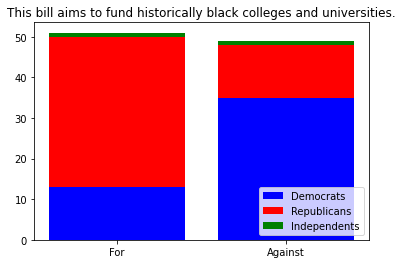

In [ ]:
educ_bill  = "This bill aims to fund historically black colleges and universities."
educ_votes = votesToDataFrame(predictBillVotes(educ_bill))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(educ_votes)

dataFrameToGraph(educ_votes, title = educ_bill)

,Name,Degree of belief,Vote,Party,State
0,Shelby,2.453170,Y,republican,Alabama
1,Tuberville,2.428835,Y,republican,Alabama
2,Murkowski,2.214296,Y,republican,Alaska
3,Sullivan,1.942560,Y,republican,Alaska
4,Kelly,1.873743,N,democrat,Arizona
5,Sinema,1.730976,N,democrat,Arizona
6,Boozman,2.770632,Y,republican,Arkansas
7,Cotton,2.213062,Y,republican,Arkansas
8,Feinstein,1.922631,N,democrat,California
9,Padilla,1.947401,N,democrat,California


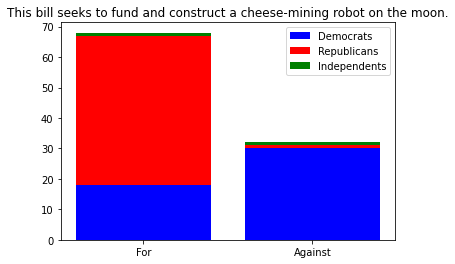

In [ ]:
cheese_bill  = "This bill seeks to fund and construct a cheese-mining robot on the moon."
cheese_votes = votesToDataFrame(predictBillVotes(cheese_bill))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(cheese_votes)

dataFrameToGraph(cheese_votes, title = cheese_bill)

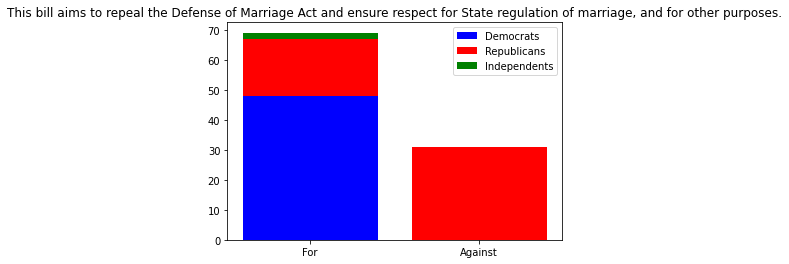

In [ ]:
respect_bill = "This bill aims to repeal the Defense of Marriage Act and ensure respect for State regulation of marriage, and for other purposes."
respect_votes = votesToDataFrame(predictBillVotes(respect_bill))

#Uncomment this to see each senator's vote
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(respect_votes)

dataFrameToGraph(respect_votes, title = respect_bill)

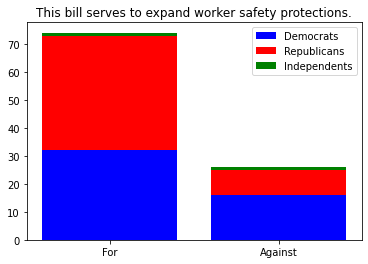

In [ ]:
safety_bill = "This bill serves to expand worker safety protections."
safety_votes = votesToDataFrame(predictBillVotes(safety_bill))

#Uncomment this to see each senator's vote
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(safety_votes)

dataFrameToGraph(safety_votes, title = safety_bill)

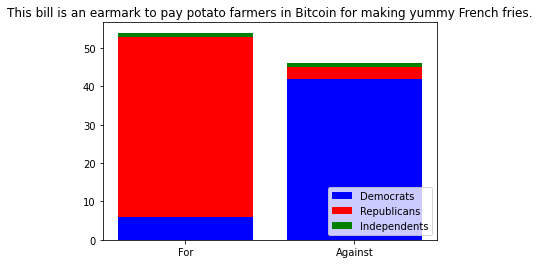

In [ ]:
potato_bill = "This bill is an earmark to pay potato farmers in Bitcoin for making yummy French fries."
potato_votes = votesToDataFrame(predictBillVotes(potato_bill))

#Uncomment this to see each senator's vote
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(potato_votes)

dataFrameToGraph(potato_votes, title = potato_bill)

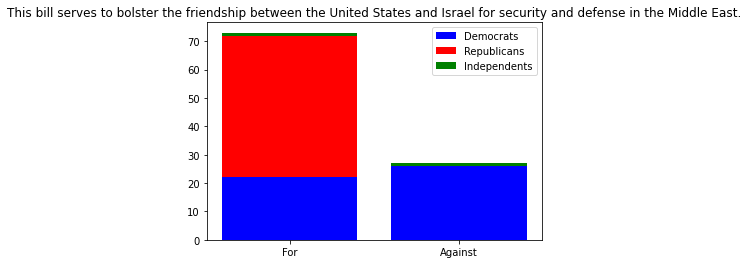

In [ ]:
mid_east_bill = "This bill serves to bolster the friendship between the United States and Israel for security and defense in the Middle East."
mid_east_votes = votesToDataFrame(predictBillVotes(mid_east_bill))

#Uncomment this to see each senator's vote
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(mid_east_votes)

dataFrameToGraph(mid_east_votes, title = mid_east_bill)

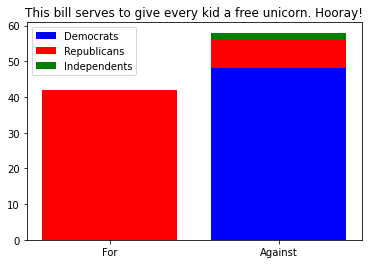

In [ ]:
unicorn_bill = "This bill serves to give every kid a free unicorn. Hooray!"
unicorn_votes = votesToDataFrame(predictBillVotes(unicorn_bill))

#Uncomment this to see each senator's vote
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(unicorn_votes)

dataFrameToGraph(unicorn_votes, title = unicorn_bill)

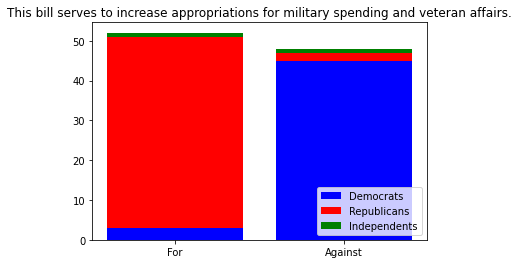

In [ ]:
mil_bill = "This bill serves to increase appropriations for military spending and veteran affairs."
mil_votes = votesToDataFrame(predictBillVotes(mil_bill))

#Uncomment this to see each senator's vote
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(mil_votes)

dataFrameToGraph(mil_votes, title = mil_bill)

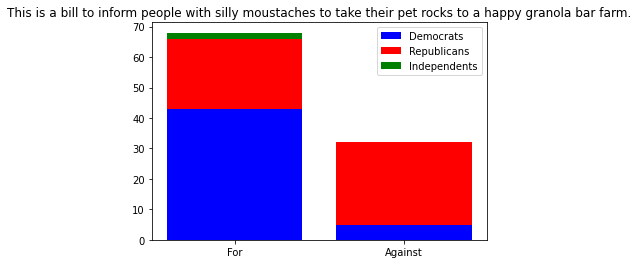

In [ ]:
silly_bill = "This is a bill to inform people with silly moustaches to take their pet rocks to a happy granola bar farm."
silly_votes = votesToDataFrame(predictBillVotes(silly_bill))

#Uncomment this to see each senator's vote
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(silly_votes)

dataFrameToGraph(silly_votes, title = silly_bill)

In [ ]:
# Download a zip file of our check point
!zip -r training_checkpoint_stuff.zip training_output/checkpoint-500/

  adding: training_output/checkpoint-500/ (stored 0%)
  adding: training_output/checkpoint-500/optimizer.pt (deflated 38%)
  adding: training_output/checkpoint-500/training_args.bin (deflated 49%)
  adding: training_output/checkpoint-500/scheduler.pt (deflated 49%)
  adding: training_output/checkpoint-500/trainer_state.json (deflated 69%)
  adding: training_output/checkpoint-500/config.json (deflated 47%)
  adding: training_output/checkpoint-500/rng_state.pth (deflated 27%)
  adding: training_output/checkpoint-500/pytorch_model.bin (deflated 8%)


Now, if we ever want to call our fine-tuned model in future code, we don't need to retrain it. We can unzip `training_checkpoint_stuff.zip` then call the following code to get our tokenizer and model back from where we left off:
```python
tokenizer = AutoTokenizer.from_pretrained("./training_output/checkpoint-500")
model = AutoModel.from_pretrained("./training_output/checkpoint-500")
```